In [1]:
# https://datascience-enthusiast.com/R/ML_python_R_part2.html
library(readxl)
library(tidyverse)
library(xgboost)
library(caret)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




## import data and check data attributes (NAs, column d_types, etc.)

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

In [4]:
ml_data

,avg_perc_change,new_case_count_sum,religion,civic,charitable,fraternal,union,voteage,local,state,...,politicalacts,ethnic,ethnichpn,education,incomeequal,employ,genderincome,language,commu,nonelder
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Kent County, Delaware",-0.10410000,6374,0.04128665,0.09236666,0.5138504,0.3680297,0.3876543,0.5415052,0.11346269,0.25280786,...,0.5021771,0.3970396,0.7951538,0.6537678,0.5456621,0.502883500,0.1139325500,0.9028321,0.9300119,0.9998395
"New Castle County, Delaware",-0.10694205,17440,0.02607471,0.10866666,0.4709141,0.2620818,0.5456790,0.5250972,0.08217630,0.13572581,...,0.5428157,0.3789706,0.7014812,0.6364562,0.4657534,0.579008040,0.0697858300,0.8534756,0.9332486,0.9999564
"Sussex County, Delaware",0.07530081,6625,0.06673288,0.08693332,0.1149585,0.1003717,0.2641975,0.5858911,0.09865325,0.16121109,...,0.3149492,0.5357585,0.7088547,0.5315682,0.4954338,0.477508660,0.0725594200,0.9003864,0.9184142,0.9998007
"Calhoun County, Alabama",-0.01198159,4954,0.14416942,0.09779999,0.2728532,0.2825279,0.2740741,0.5931206,0.14542660,0.10854987,...,0.2989840,0.4907753,0.8822994,0.6344196,0.4383562,0.389850080,0.2552950400,0.9534703,0.8962063,0.9997735
"Colbert County, Alabama",-0.80248864,1936,0.15907682,0.06519999,0.2880887,0.2713755,0.3308642,0.6142046,0.18445593,0.08697174,...,0.2235123,0.5912497,0.9221585,0.5814664,0.4794521,0.452133770,0.2414003000,0.9728736,0.9124165,0.9994222
"Cullman County, Alabama",0.15002955,4038,0.17756705,0.08149999,0.2188366,0.2676580,0.3753086,0.5765867,0.15217362,0.08567087,...,0.1770682,0.8998702,0.8476726,0.6059063,0.4566210,0.470588270,0.0774006840,0.9561338,0.8671177,0.9996407
"Dale County, Alabama",-0.25647727,3255,0.12937844,0.07606666,0.2396122,0.2397769,0.3333333,0.5566893,0.15729527,0.06966214,...,0.2975327,0.4786251,0.8013721,0.6476579,0.5045662,0.445213380,0.4270797400,0.9349950,0.8601150,0.9994912
"Escambia County, Alabama",-0.08107500,2295,0.20798197,0.07606666,0.2313019,0.2118959,0.3259259,0.5969077,0.23886412,0.13833724,...,0.1930334,0.3449723,0.9254362,0.4439918,0.4132420,0.322952700,0.0002392530,0.9835584,0.7481605,0.9992800
"Etowah County, Alabama",-0.17976136,4459,0.15017657,0.08149999,0.3144044,0.2936803,0.3679012,0.5862101,0.20284905,0.09484407,...,0.2815675,0.6019641,0.8806388,0.5651731,0.4383562,0.393310280,0.0658689740,0.9687377,0.8775314,0.9997147


## create test & train set indices with 80% of data using the caret package

In [5]:
set.seed(1)  # For reproducibility

# Create index for testing and training data
inTrain <- createDataPartition(y = ml_data$avg_perc_change, p = 0.8, list = FALSE)

# subset ml_data to train
training <- ml_data[inTrain,]


# subset the rest to test
testing <- ml_data[-inTrain,]

## convert test & train set to DMatrixes as DMatrix is the recommended class for xgboost

In [6]:
X_train = xgb.DMatrix(as.matrix(training %>% select(-avg_perc_change)))

y_train = training$avg_perc_change

X_test = xgb.DMatrix(as.matrix(testing %>% select(-avg_perc_change)))
y_test = testing$avg_perc_change

## specify cross-validation method, number of k-folds and enable parallel computation 

In [7]:
xgb_trcontrol = trainControl(
  method = "cv",
  number = 5,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

## definte the grid space to search for the best hyperparameters

In [8]:
xgbGrid <- expand.grid(nrounds = c(100,200),
                       max_depth = c(10, 15, 20, 25),
                       colsample_bytree = seq(0.5, 0.9, length.out = 5),
                       # values specified below are sklearn-api default values
                       eta = 0.1,
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1
                      )

## train the model

In [10]:
set.seed(1) 

xgb_model = train(
  X_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

## best hyperparameter values

In [12]:
xgb_model$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32,200,25,0.1,0,0.5,1,1


## evaluate the model

In [14]:
predicted = predict(xgb_model, X_test)
residuals = y_test - predicted
RMSE = sqrt(mean(residuals^2))

cat('The root mean square error of the test data is ', RMSE, '\n')

The root mean square error of the test data is  0.1696668 


In [15]:
y_test_mean = mean(y_test)

# Calculate total sum of squares
tss =  sum((y_test - y_test_mean)^2 )

# Calculate residual sum of squares
rss =  sum(residuals^2)

# Calculate R-squared
rsq  =  1 - (rss/tss)
cat('The R-square of the test data is ', round(rsq,3), '\n')

The R-square of the test data is  -0.147 


## plot actual vs predicted 

`geom_smooth()` using formula 'y ~ x'



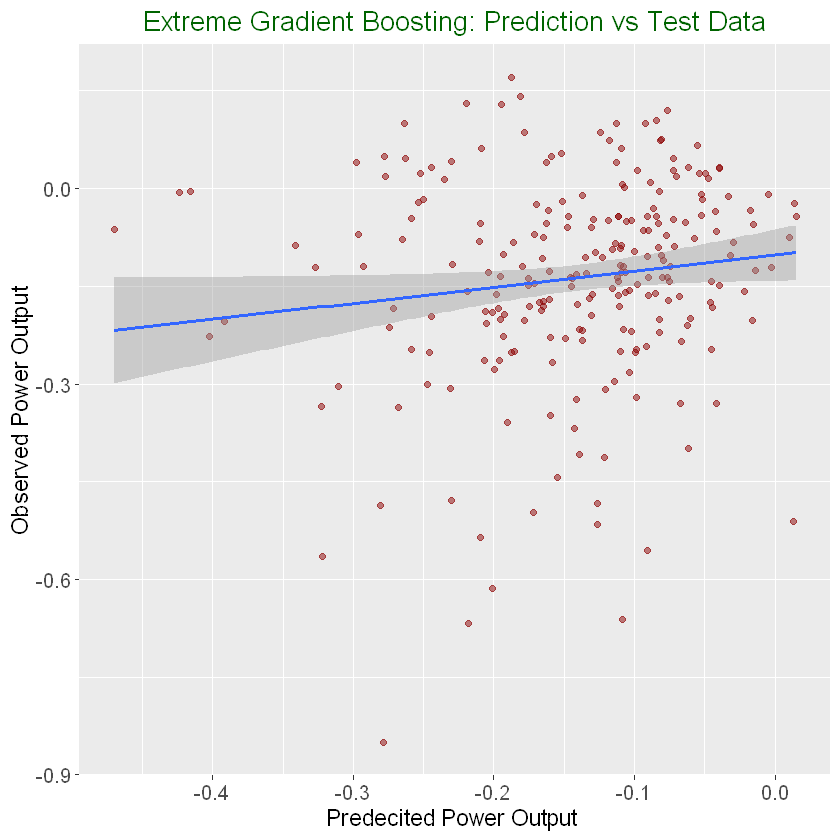

In [16]:
my_data = as.data.frame(cbind(predicted = predicted,
                            observed = y_test))

# Plot predictions vs test data

ggplot(my_data,aes(predicted, observed)) + geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm)+ ggtitle('Linear Regression ') + ggtitle("Extreme Gradient Boosting: Prediction vs Test Data") +
      xlab("Predecited Power Output ") + ylab("Observed Power Output") + 
        theme(plot.title = element_text(color="darkgreen",size=16,hjust = 0.5),
         axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
         axis.title.x = element_text(size=14), axis.title.y = element_text(size=14))

In [17]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [18]:
naive_roc_auc_score(y_test, predicted)

[1] 0.5564371